# IBM Data Science Capstone Project:

# New Yorkers live in Toronto with Data Science

## A. Introduction

The quaility of life is one of pursuances in our life. Someone live in New York with high pressures may want to move to a place which is slow pace. At this moment, Toronto would be a good choice. There are three reasons to support this decision. First, the weather is similar with New York. Second, the distance between New York and Toronto is about 1.5 hours flight time. Third, the [cost of living index](https://www.numbeo.com/cost-of-living/rankings_current.jsp) in Toronto is 72.26 which is much lower than New York(100).
However, How do we choose a community or a borough in Toronto if I originally live in New York? This report can provide a point of view to let you find similar Toronto places with the place you live in New York by Data Science. Moreover, the [Foursquare API](https://developer.foursquare.com/docs/places-api/endpoints/) is used to explore neighborhoods in both cities. The **explore** function is to get the most common venue categories in each neighborhood, and then to group the neighborhoods into clusters. The k-means clustering algorithm is to complete this task. The 10 clusters would be generated to let users to find similar communites between New York Cidy and Toronto. Finally, the Folium library is to visualize the neighborhoods in New York City and Toronto with emerging clusters.

## B. Tools and Data

### B.1 Tools

* Jupyter Notebook is used to execute the python program and describe the logics with figures and charts in the browser.
* Numpy is a library to handle data in a vectorized manner.
* Pandas is a library for data analsysis.
* Geopy is to convert an address into latitude and longitude values.
* Matplotlib and Seaborn library is used to make the chart to show the correlation among the variables.
* Folium library is used to visualize geographic details of Seattle and its clustering marks can demonstrate the number of vehicle accidents.import numpy as np # library to handle data in a vectorized manner.
* Foursquare API is to explore neighborhoods.
* Sklearn library is to import the k-means clustering method.

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim# convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

### B.2 Data

The Location Data is from previous Applied Data Science Capstone assignment. 
Neighborhood in New York has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. Here is [New York neighborhood dataset](https://geo.nyu.edu/catalog/nyu_2451_34572) from NYU. 
Neighborhood in Toronto has a total of 5 boroughs and 103 neighborhoods. There is no dataset for Toronto neighborhood, so the web scraping is used to get information from [wiki](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). At the meantime, the coordinate information of Toronto is from Couresera content. Combining the web scraping result and coordinate data is to build the Toronto neighborhood dataset.

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('New York Data downloaded!')

New York Data downloaded!


In [3]:
ny_neighborhoods_data = newyork_data['features']

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)

for data in ny_neighborhoods_data:
    borough = ny_neighborhood_name = data['properties']['borough'] 
    ny_neighborhood_name = data['properties']['name']
        
    ny_neighborhood_latlon = data['geometry']['coordinates']
    ny_neighborhood_lat = ny_neighborhood_latlon[1]
    ny_neighborhood_lon = ny_neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': ny_neighborhood_name,
                                          'Latitude': ny_neighborhood_lat,
                                          'Longitude': ny_neighborhood_lon}, ignore_index=True)
    
ny_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [37]:
print('There are {} boroughs and {} neighborhoods in New York.'.format(
        len(ny_neighborhoods['Borough'].unique()),
        ny_neighborhoods.shape[0]
    )
)

There are 5 boroughs and 306 neighborhoods in New York.


In [6]:
ny_address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [7]:
# map_display function
def map_display(location, neighborhoods):
    # create map of New York using latitude and longitude values
    map_location = folium.Map(location=[location["latitude"], location["longitude"]], zoom_start=11)
    
    # add markers to map function
    for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_location)  
        
    return map_location

In [31]:
ny_location = {"latitude": ny_latitude, "longitude": ny_longitude}  
map_display(ny_location, ny_neighborhoods)

In [8]:
!pip install beautifulsoup4
from bs4 import BeautifulSoup
import requests as rq

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = rq.get(url)
html_doc = response.text

soup = BeautifulSoup(html_doc, 'html.parser')

toronto_postal_table = soup.find('table', {'class': 'wikitable sortable'})

columns = [th.text.replace('\n', '') for th in toronto_postal_table.find('tr').find_all('th')]

# Unify typo
columns = ['Neighborhood' if x=='Neighbourhood' else x for x in columns]

trs = toronto_postal_table.find_all('tr')[1:]
rows = list()
for tr in trs:
    toronto_postal_row = []
    for td in tr.find_all('td'):
        toronto_postal_row.append(td.text.replace('\n', ''))
        
    if (toronto_postal_row[1] != 'Not assigned'):
        if (toronto_postal_row[2] == 'Not assigned'):
            toronto_postal_row[2] = toronto_postal_row[1]
        rows.append(toronto_postal_row)

tor_postal_df = pd.DataFrame(data=rows, columns=columns)

tor_postal_df.head()

     |████████████████████████████████| 122kB 7.5MB/s eta 0:00:01


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [33]:
# Toronto coordinates
tor_cor_df = pd.read_csv('Geospatial_Coordinates.csv')

# join postal_df and cor_df
tor_neighborhoods = pd.merge(tor_postal_df,tor_cor_df)

tor_neighborhoods.head()

103


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [38]:
print('There are {} boroughs and {} neighborhoods in Toronto.'.format(
        len(tor_neighborhoods['Borough'].unique()),
        tor_neighborhoods.shape[0]
    )
)

There are 10 boroughs and 103 neighborhoods in Toronto.


In [10]:
tor_address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
tor_location = geolocator.geocode(tor_address)
tor_latitude = tor_location.latitude
tor_longitude = tor_location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(tor_latitude, tor_longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [32]:
tor_location = {"latitude": tor_latitude, "longitude": tor_longitude}  
map_display(tor_location, tor_neighborhoods)

## C. Results

### C.1 Neighborhood Exploring in New York and Toronto

Exploring neighborhood is to identify the borough conditions. The Foursquare API is used to explore the categoried neighborhood. Using this API to get the top 100 venues are in speicfic coordinate within a radius of 5000 meters. Extracting the categories of top 100 venues is to build the features of this borough. In order to building the system for comparing New York and Toronto, Only common categories are selected.

In [11]:
CLIENT_ID = 'LKQJXMBAG5KU3RLSGFUVQIG2USY5V4HIVVTUMSRCFHPGXIFX' # Foursquare ID
CLIENT_SECRET = 'NBSF41BFTF3K55L5J2E5NUMGUNNFZK4304ODLGKXMB1PRBI3' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [12]:
def getNearbyVenues(venue_file, names, latitudes, longitudes, radius=1000):
    venues_list=[]
    venue_columns = ['Neighborhood', 
                 'Neighborhood Latitude', 
                 'Neighborhood Longitude', 
                 'Venue', 
                 'Venue Latitude', 
                 'Venue Longitude', 
                 'Venue Category']
    try:
        nearby_venues = pd.read_csv(venue_file, index_col=0)
    except FileNotFoundError: 
        nearby_venues = pd.DataFrame(columns = venue_columns)
    
    old_nearby_list = nearby_venues['Neighborhood'].tolist()
        
    for name, lat, lng in zip(names, latitudes, longitudes):
        if name in old_nearby_list:
            #print(name + ' is already checked')
            continue
        
        print(name + ' is checking')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            response = requests.get(url).json()
            if len(response["response"]) != 0:
                results = response["response"]['groups'][0]['items']
            else:
                raise Exception(response["meta"])
        except Exception as e:
            print('---exception---')
            print(e)
            
        if 'results' in locals():
        # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    new_nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    if not new_nearby_venues.empty:
        new_nearby_venues.columns = venue_columns
    
        nearby_venues=nearby_venues.append(new_nearby_venues,ignore_index=True)
    
        nearby_venues.to_csv(venue_file)
    
    return(nearby_venues)


In [13]:
ny_venues = getNearbyVenues(venue_file='ny_nearby_venues.csv',
                            names=ny_neighborhoods['Neighborhood'],
                            latitudes=ny_neighborhoods['Latitude'],
                            longitudes=ny_neighborhoods['Longitude']
                                  )

print(ny_venues.shape)
ny_venues.head()

(20492, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop


In [14]:
tor_venues = getNearbyVenues(venue_file='tor_nearby_venues.csv',
                             names=tor_neighborhoods['Neighborhood'],
                             latitudes=tor_neighborhoods['Latitude'],
                             longitudes=tor_neighborhoods['Longitude']
                            )

print(tor_venues.shape)
tor_venues.head()

Upper Rouge is checking
(4878, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store
4,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant


In [15]:
# ny_common_venues.groupby('Neighborhood').count()
print('There are {} uniques categories in New York.'.format(len(ny_venues['Venue Category'].unique())))

There are 471 uniques categories in New York.


In [16]:
# tor_common_venues.groupby('Neighborhood').count()
print('There are {} uniques categories in Toronto.'.format(len(tor_venues['Venue Category'].unique())))

There are 334 uniques categories in Toronto.


In [17]:
# Find intersected catgories between New York and Torondo
ny_venues_set = list(ny_venues['Venue Category'].unique())
tor_venues_set = list(tor_venues['Venue Category'].unique())
ny_tor_venues = list(set(ny_venues_set) & set(tor_venues_set))

print('There are {} common categories between New York and Toronto.'.format(len(ny_tor_venues)))

There are 300 common categories between New York and Toronto.


In [18]:
ny_common_venues = ny_venues[ny_venues['Venue Category'].isin(ny_tor_venues)]
tor_common_venues = tor_venues[tor_venues['Venue Category'].isin(ny_tor_venues)]

print(ny_common_venues.shape)
print(tor_common_venues.shape)
ny_common_venues.head()

(19562, 7)
(4816, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop


### C.2 Analyze Each Neighborhood

In [19]:
# New York venues one hot encoding
ny_common_onehot = pd.get_dummies(ny_common_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_common_onehot['Neighborhood'] = ny_common_venues['Neighborhood'] 
ny_common_onehot['City'] = 'NY'

# move neighborhood column to the first column
reorder_columns = [ny_common_onehot.columns[-1]] + list(ny_common_onehot.columns[:-1])
ny_common_onehot = ny_common_onehot[reorder_columns]

ny_common_onehot.head()

,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restau

In [20]:
# Tornoto venues one hot encoding
tor_common_onehot = pd.get_dummies(tor_common_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_common_onehot['Neighborhood'] = tor_common_venues['Neighborhood'] 
tor_common_onehot['City'] = 'TOR'

# move neighborhood column to the first column
reorder_columns = [tor_common_onehot.columns[-1]] + list(tor_common_onehot.columns[:-1])
tor_common_onehot = tor_common_onehot[reorder_columns]

tor_common_onehot.head()

,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restau

Combining neighborhood dataset in New York and Toronto group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [21]:
ny_tor_onehot = pd.concat([ny_common_onehot,tor_common_onehot],axis=0)
ny_tor_grouped = ny_tor_onehot.groupby(['City','Neighborhood']).mean()
ny_tor_grouped.reset_index(drop=False, inplace=True)
ny_tor_grouped.head()

,City,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restau

In [ ]:
num_top_venues = 5

for city, hood in zip(ny_tor_grouped['City'], ny_tor_grouped['Neighborhood']):
    print("----"+city+' '+hood+"----")
    temp = ny_tor_grouped[(ny_tor_grouped['Neighborhood'] == hood) & (ny_tor_grouped['City'] == city)].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[5:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City','Borough','Neighborhood','Latitude','Longitude']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

ny_neighborhoods['City'] = 'NY'
tor_neighborhoods['City'] = 'TOR'

ny_grouped_neighborhoods = pd.merge(ny_neighborhoods, ny_tor_grouped, on=['City', 'Neighborhood'])
tor_grouped_neighborhoods = pd.merge(tor_neighborhoods, ny_tor_grouped, on=['City', 'Neighborhood'])
ny_tor_grouped_neighborhoods = pd.concat([ny_grouped_neighborhoods, tor_grouped_neighborhoods])
ny_tor_grouped_neighborhoods.reset_index(inplace=True)
ny_tor_grouped_neighborhoods.drop(['Postal Code', 'index'], axis=1, inplace=True)

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['City'] = ny_tor_grouped_neighborhoods['City']
neighborhoods_venues_sorted['Neighborhood'] = ny_tor_grouped_neighborhoods['Neighborhood']
neighborhoods_venues_sorted['Borough'] = ny_tor_grouped_neighborhoods['Borough']
neighborhoods_venues_sorted['Latitude'] = ny_tor_grouped_neighborhoods['Latitude']
neighborhoods_venues_sorted['Longitude'] = ny_tor_grouped_neighborhoods['Longitude']

for ind in np.arange(ny_tor_grouped_neighborhoods.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 5:] = return_most_common_venues(ny_tor_grouped_neighborhoods.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.tail()

,City,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
403,TOR,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,Coffee Shop,Pizza Place,Park,Italian Restaurant,Bank,Pub,Burger Joint,Sushi Restaurant,French Restaurant,Dessert Shop
404,TOR,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,Coffee Shop,Japanese Restaurant,Men's Store,Park,Café,Sushi Restaurant,Gay Bar,Restaurant,Hotel,Bookstore
405,TOR,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Park,Coffee Shop,Brewery,Pizza Place,Bakery,Sushi Restaurant,Fast Food Restaurant,Italian Restaurant,Farmers Market,Beach
406,TOR,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,Park,Ice Cream Shop,Gym / Fitness Center,Italian Restaurant,Shopping Mall,Bus Stop,Eastern European Restaurant,Filipino Restaurant,Farm,Farmers Market
407,TOR,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Restaurant,Gym / Fitness Center,Burrito Place,Convenience Store,Burger Joint,Bank,Bakery,Grocery Store,Sushi Restaurant,Gym


### C.3 Cluster Neighborhoods

In [24]:
# set number of clusters
kclusters = 10

ny_tor_grouped_clustering = ny_tor_grouped_neighborhoods.drop(['City','Neighborhood','Borough', 'Latitude', 'Longitude'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
cluster_labels = np.array(kmeans.labels_) + 1

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(5, 'Cluster Labels', cluster_labels)
neighborhoods_venues_sorted.tail()

,City,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
403,TOR,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,3,Coffee Shop,Pizza Place,Park,Italian Restaurant,Bank,Pub,Burger Joint,Sushi Restaurant,French Restaurant,Dessert Shop
404,TOR,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,3,Coffee Shop,Japanese Restaurant,Men's Store,Park,Café,Sushi Restaurant,Gay Bar,Restaurant,Hotel,Bookstore
405,TOR,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,3,Park,Coffee Shop,Brewery,Pizza Place,Bakery,Sushi Restaurant,Fast Food Restaurant,Italian Restaurant,Farmers Market,Beach
406,TOR,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,8,Park,Ice Cream Shop,Gym / Fitness Center,Italian Restaurant,Shopping Mall,Bus Stop,Eastern European Restaurant,Filipino Restaurant,Farm,Farmers Market
407,TOR,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,3,Restaurant,Gym / Fitness Center,Burrito Place,Convenience Store,Burger Joint,Bank,Bakery,Grocery Store,Sushi Restaurant,Gym


In [40]:
# create new york map
ny_map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Latitude'], neighborhoods_venues_sorted['Longitude'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(ny_map_clusters)
       
ny_map_clusters

In [41]:
# create new york map
tor_map_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Latitude'], neighborhoods_venues_sorted['Longitude'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tor_map_clusters)
       
tor_map_clusters

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

dict_values([66, 4, 81, 1, 119, 0, 1, 2, 8, 24])
dict_values([3, 48, 46, 0, 1, 1, 0, 2, 0, 1])


<AxesSubplot:>

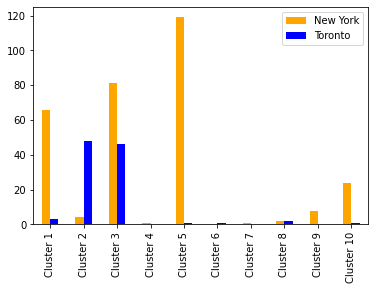

In [29]:
ny_clusters = dict(neighborhoods_venues_sorted[neighborhoods_venues_sorted['City'] == 'NY'].groupby(['Cluster Labels']).size())
tor_clusters = dict(neighborhoods_venues_sorted[neighborhoods_venues_sorted['City'] == 'TOR'].groupby(['Cluster Labels']).size())

for i in range(10):
    try:
        ny_clusters[i+1]
    except:
        ny_clusters[i+1] = 0
        
    try:
        tor_clusters[i+1]
    except:
        tor_clusters[i+1] = 0

sorted_ny_clusters = dict(sorted(ny_clusters.items())).values()
sorted_tor_clusters = dict(sorted(tor_clusters.items())).values()
print(sorted_ny_clusters)
print(sorted_tor_clusters)

#sorting by index
cluster_key = []
for i in range(10):
    cluster_key.append('Cluster ' + str(i + 1))

cluster_df = pd.DataFrame({"New York": sorted_ny_clusters, "Toronto": sorted_tor_clusters}, index=cluster_key)
cluster_df.plot.bar(color=['Orange', 'Blue'])

In [30]:
ny_tor_common_cluster = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 3]
ny_domain_cluster = neighborhoods_venues_sorted[(neighborhoods_venues_sorted['Cluster Labels'] == 5) & (neighborhoods_venues_sorted['City'] == 'NY')]
tor_domain_cluster = neighborhoods_venues_sorted[(neighborhoods_venues_sorted['Cluster Labels'] == 2) & (neighborhoods_venues_sorted['City'] == 'TOR')]

ny_tor_common_cluster_list = np.concatenate((ny_tor_common_cluster['1st Most Common Venue'].tolist(), ny_tor_common_cluster['2nd Most Common Venue'].tolist(), ny_tor_common_cluster['3rd Most Common Venue'].tolist())).tolist()
ny_domain_cluster_list = np.concatenate((ny_domain_cluster['1st Most Common Venue'].tolist(), ny_domain_cluster['2nd Most Common Venue'].tolist(), ny_domain_cluster['3rd Most Common Venue'].tolist())).tolist()
tor_domain_cluster_list = np.concatenate((tor_domain_cluster['1st Most Common Venue'].tolist(), tor_domain_cluster['2nd Most Common Venue'].tolist(), tor_domain_cluster['3rd Most Common Venue'].tolist())).tolist()

def top10_venue(venue_list):  
    venue_dict = {venue:venue_list.count(venue) for venue in venue_list}
    total = sum(venue_dict.values())
    venue_dict = dict(sorted(venue_dict.items(), key=lambda v: v[1],reverse=True))

    for venue in venue_dict:
        venue_dict[venue] = '{:.2%}'.format(venue_dict[venue]/total)
        
    venue_df = pd.DataFrame()
    venue_df['Venue'] = venue_dict.keys()
    venue_df['Percentage'] = venue_dict.values()
    
    return(venue_df.head(10))

print('---ny_tor_common_cluster Cluster 3---')
print(top10_venue(ny_tor_common_cluster_list))
print('\n')
print('---ny_domain_cluster Cluster 5---')
print(top10_venue(ny_domain_cluster_list))
print('\n')
print('---tor_domain_cluster Cluster 2---')
print(top10_venue(tor_domain_cluster_list))

---ny_tor_common_cluster Cluster 3---
                Venue Percentage
0         Coffee Shop     19.95%
1                Café      9.19%
2  Italian Restaurant      7.35%
3                Park      7.09%
4                 Bar      6.04%
5         Pizza Place      6.04%
6              Bakery      4.46%
7               Hotel      3.67%
8          Restaurant      2.10%
9        Cocktail Bar      1.84%


---ny_domain_cluster Cluster 5---
                  Venue Percentage
0           Pizza Place     19.33%
1         Deli / Bodega      9.80%
2            Donut Shop      7.00%
3        Sandwich Place      4.76%
4    Chinese Restaurant      4.20%
5              Bus Stop      3.92%
6  Fast Food Restaurant      3.64%
7                  Park      3.36%
8              Pharmacy      3.36%
9         Grocery Store      3.08%


---tor_domain_cluster Cluster 2---
                   Venue Percentage
0            Coffee Shop     20.14%
1                   Park     10.42%
2          Grocery Store      9.0

## D. Discussion

The environment of borough is explored by analyzing the venue combination. The borough neighborhood data including the coordination and neighborhoods is from wikipedia or Couresera by web crawling or from open data. In our dataset, there are 5 boroughs and 306 neighborhoods in New York; there are 10 boroughs and 103 neighborhoods in Toronto. Moreover, The foursquare API is used to find the venues and their catgories to build the environment features. There are 471 uniques categories in New York, and 334 uniques categories in Toronto. After intersecting these two category set, there are 300 common categories between New York and Toronto. In addition, the one hot encode method is to build the frequency map of venue categories. The frequency map can be clustered by k-means and 10 clusters are generated. The top 10 venues are appended to the borough neighborhood information. At the meantime, top 3 venues are counted to further analyze. In the bar chart, the Cluster 5 is dominate on New York, the Cluster 2 is dominate on Toronto, and the Cluster 3 is both common on New York and Toronto. The top 1 coverage of venues in Cluster 3 is Coffee shop(almost 30%), these places in Cluster 3 may be in business quarter to let people to get coffee easily. Although the top 1 coverage of venues is Coffee shop(20%) in Cluster 2, the second one is Park, 10%. We can observe there are more green places in Toronto. However, The top 1 coverage of venues in Cluster 5 is Pizza Place(almost 20%). These results demonstrate the different types of these places including the culture and life style.

## E. Conclusion

Immigration or long-stay in other places are important issues. The environment analysis in this report provides a point of view to select the destination. By analyzing the neighborhood combination of targeted boroughs, the similar location with the place of departure could be choosed. This way can reduce the pressure of changing. In this report, if someone want to transfer from New York to Toronto or from Toronto to New York, they can use this map to select the targeted place they can live. Not only changing the living country but finding the familiar place to live would benifit the person or the family.